# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

1. Open account settings.
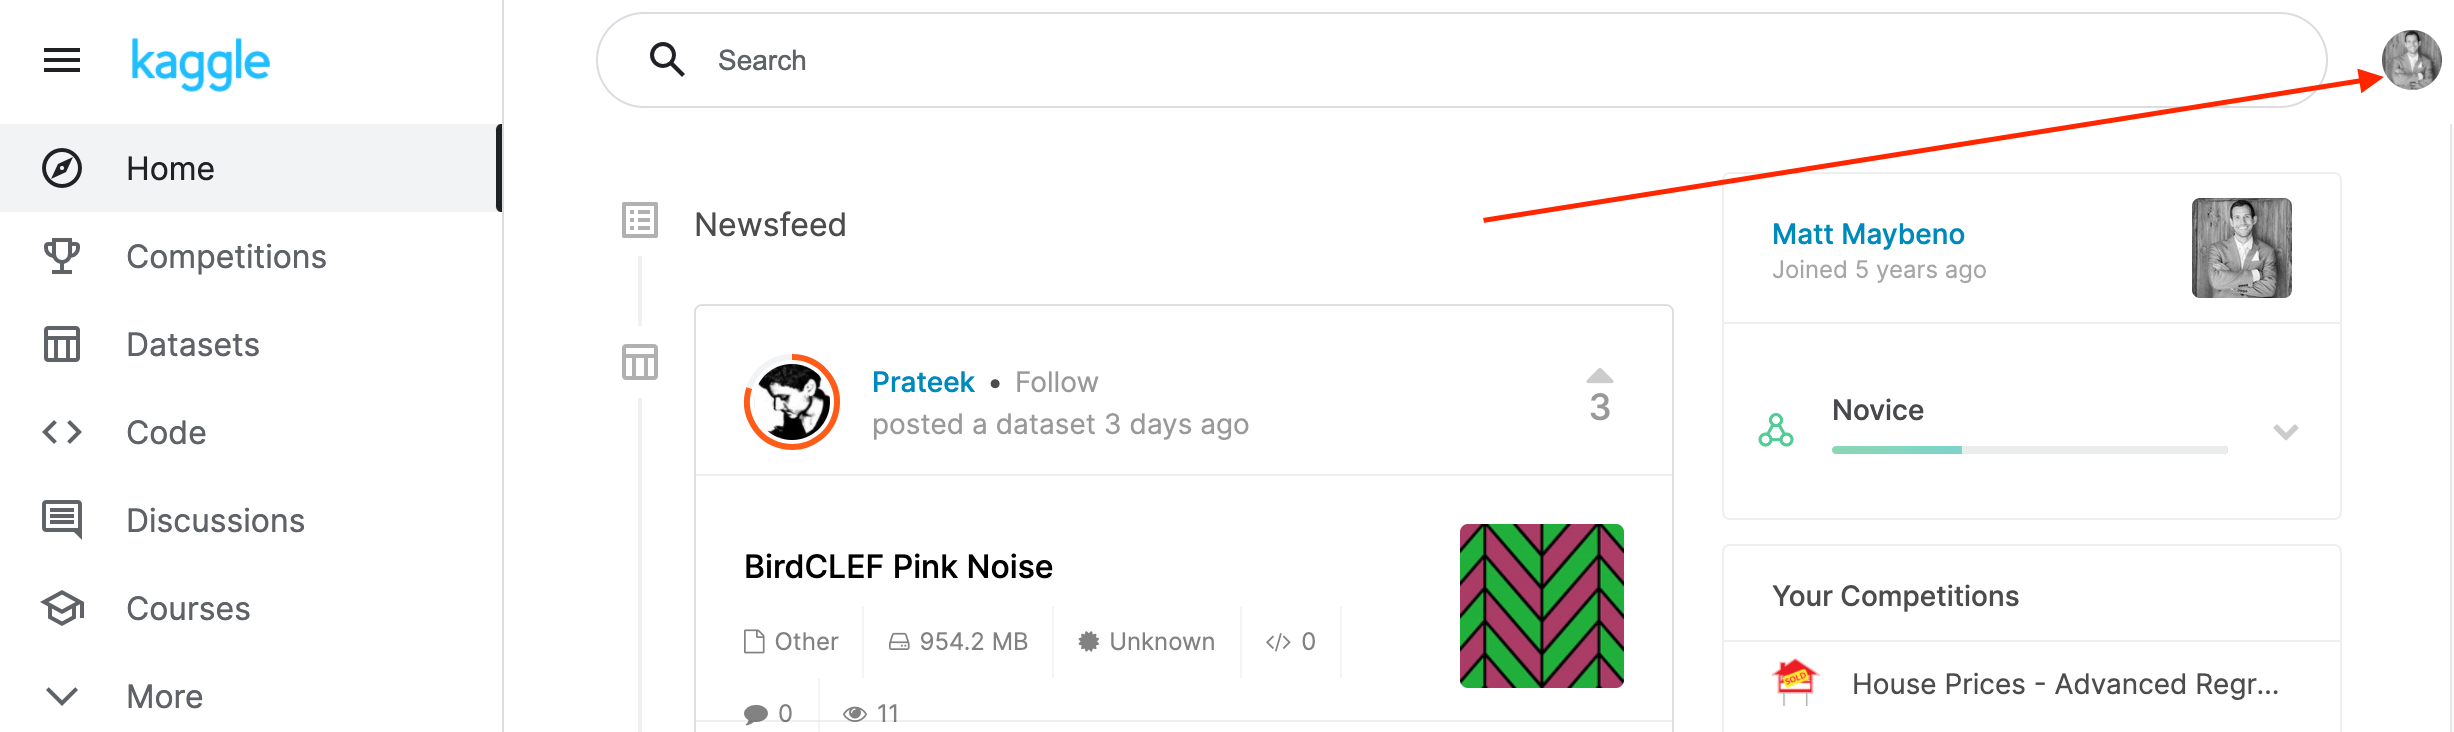
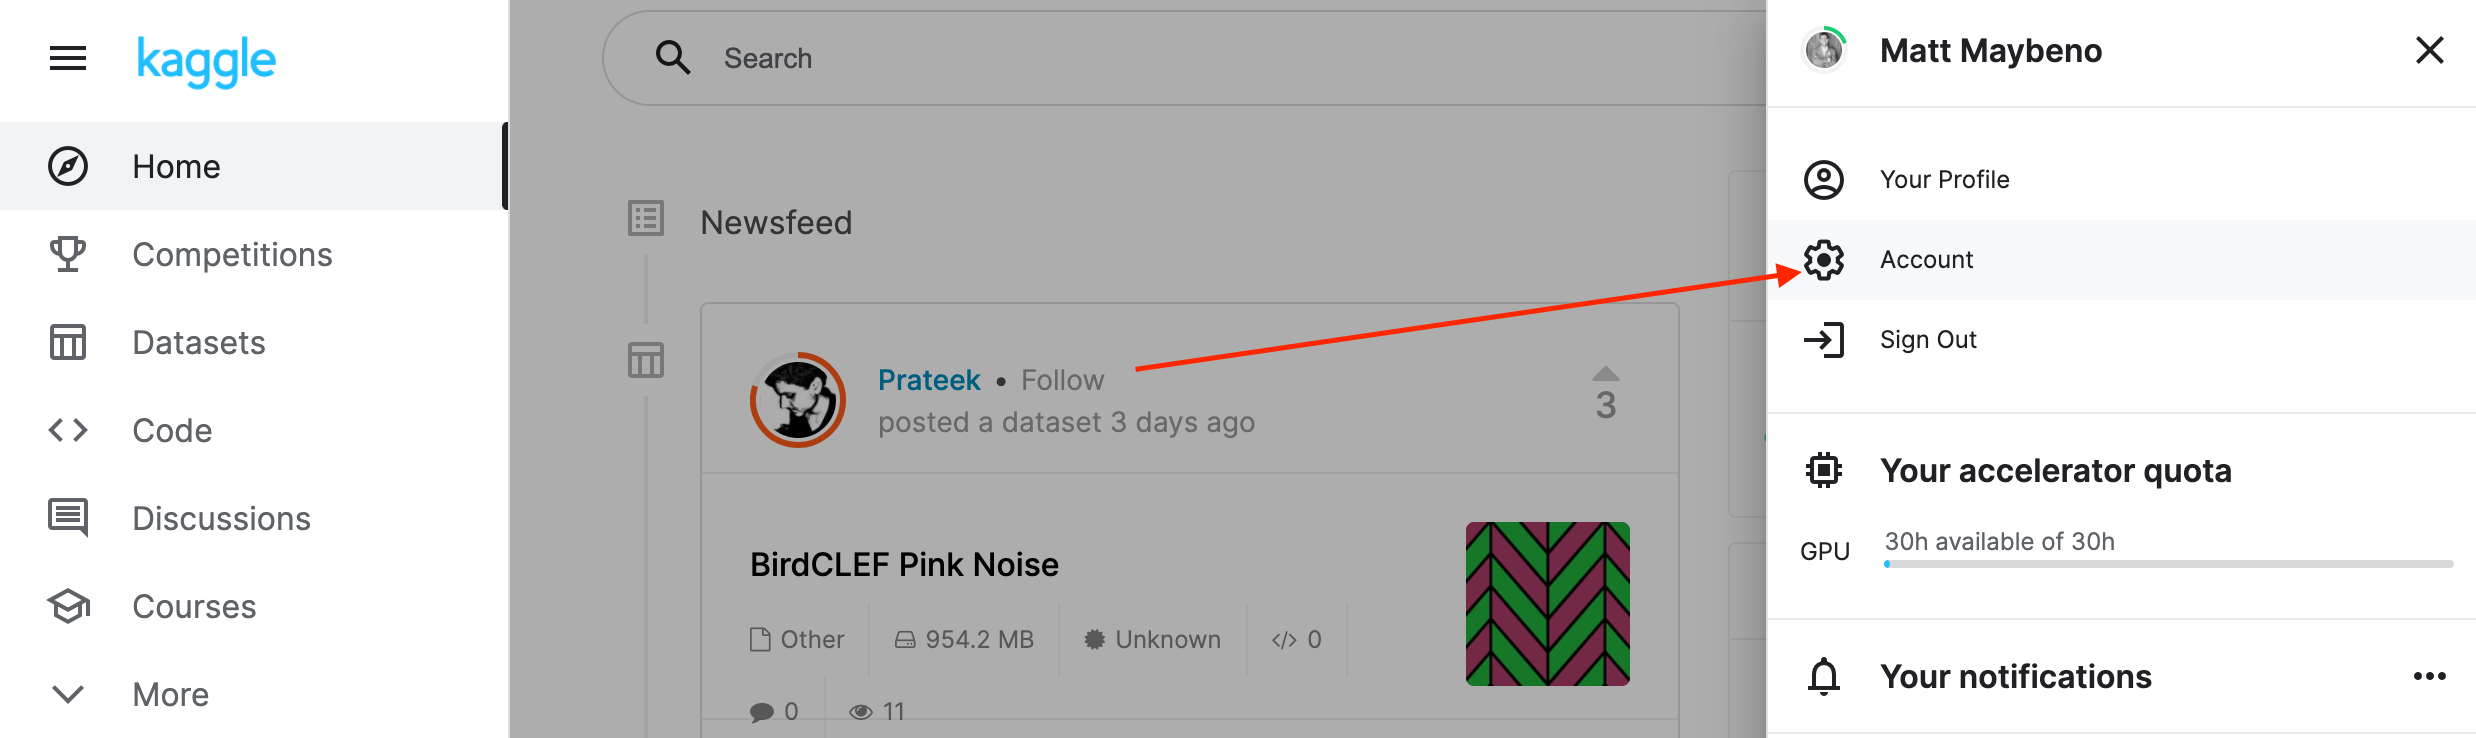
2. Scroll down to API and click Create New API Token.
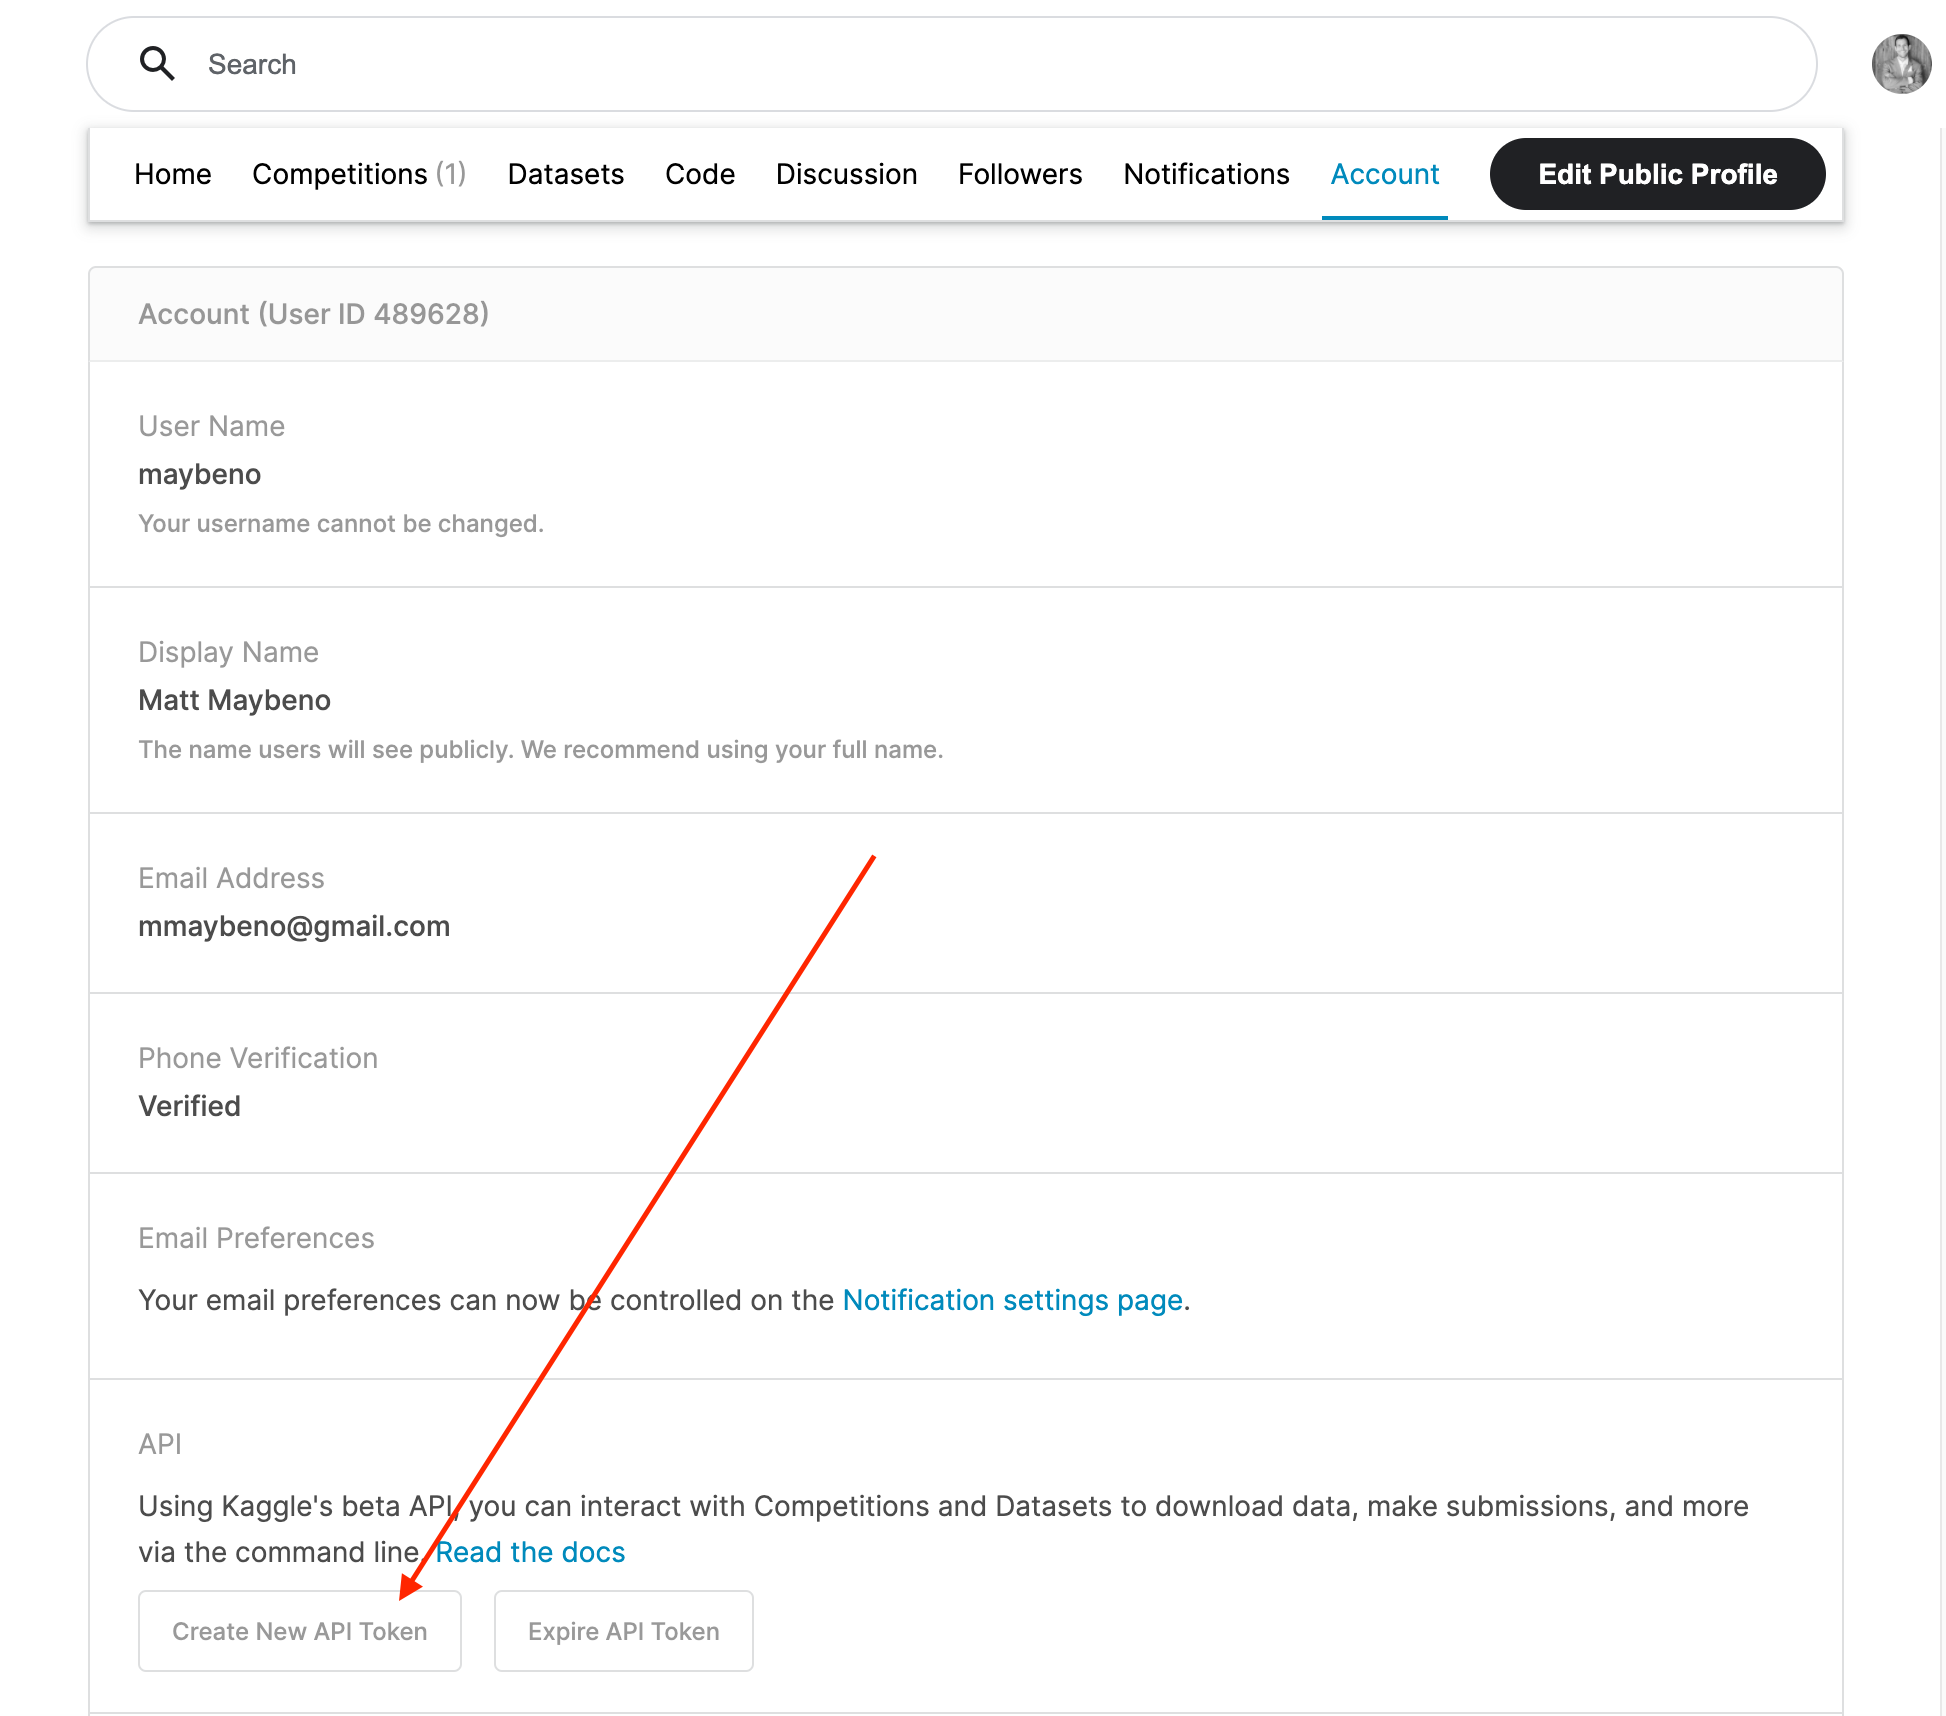
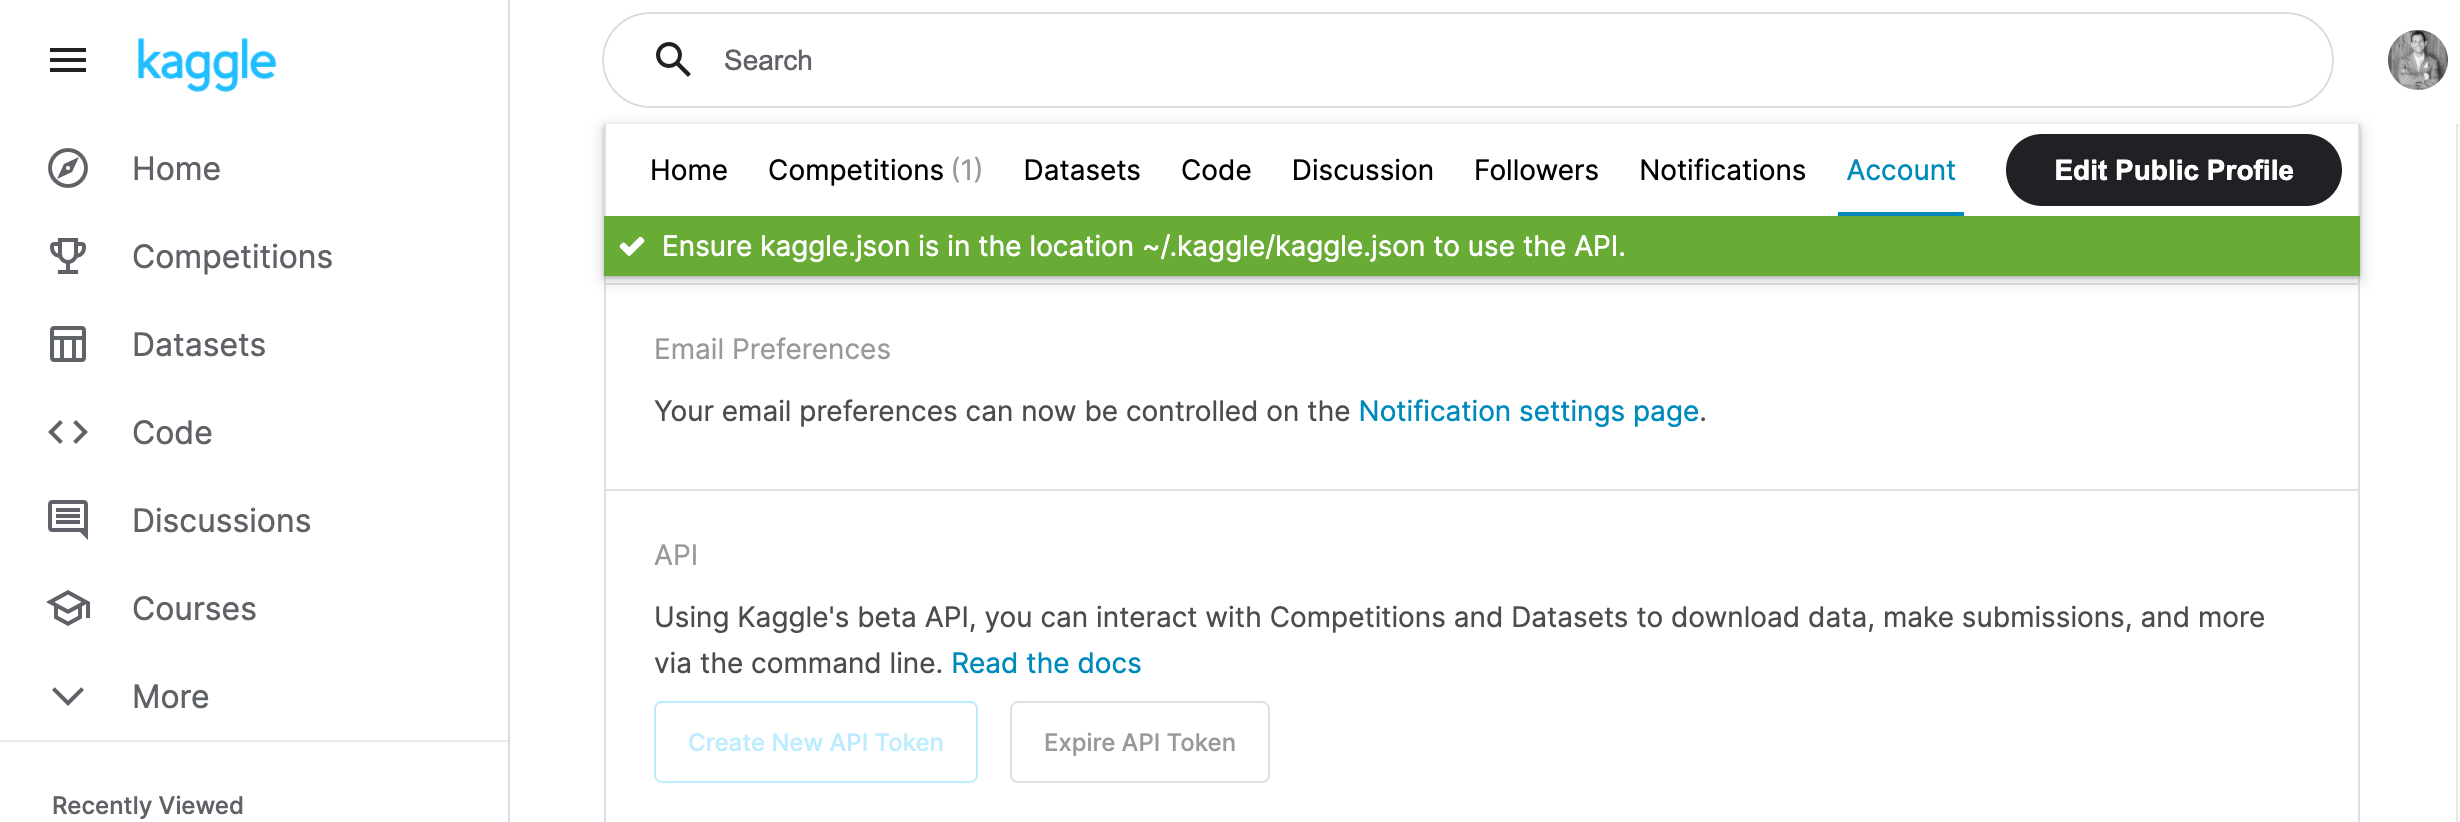
3. Open up `kaggle.json` and use the username and key.
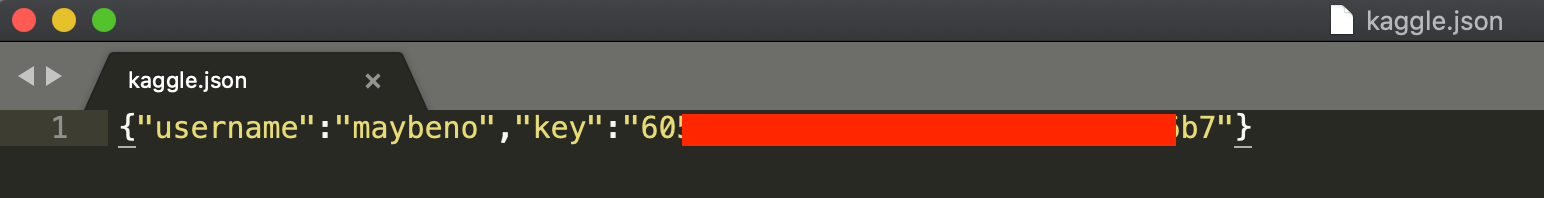

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [1]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

### Setup Kaggle API Key

In [2]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p ~/.kaggle
!touch ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
import os
import json

kaggle_username = "kanwarpreetkaur"  # Replace with your actual Kaggle username
kaggle_key = "5790acb014910a73ebe2a18aca587d50"

# Create the .kaggle directory if it doesn't exist
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

# Save API token to the kaggle.json file
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))


In [4]:
!pip install kaggle

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms
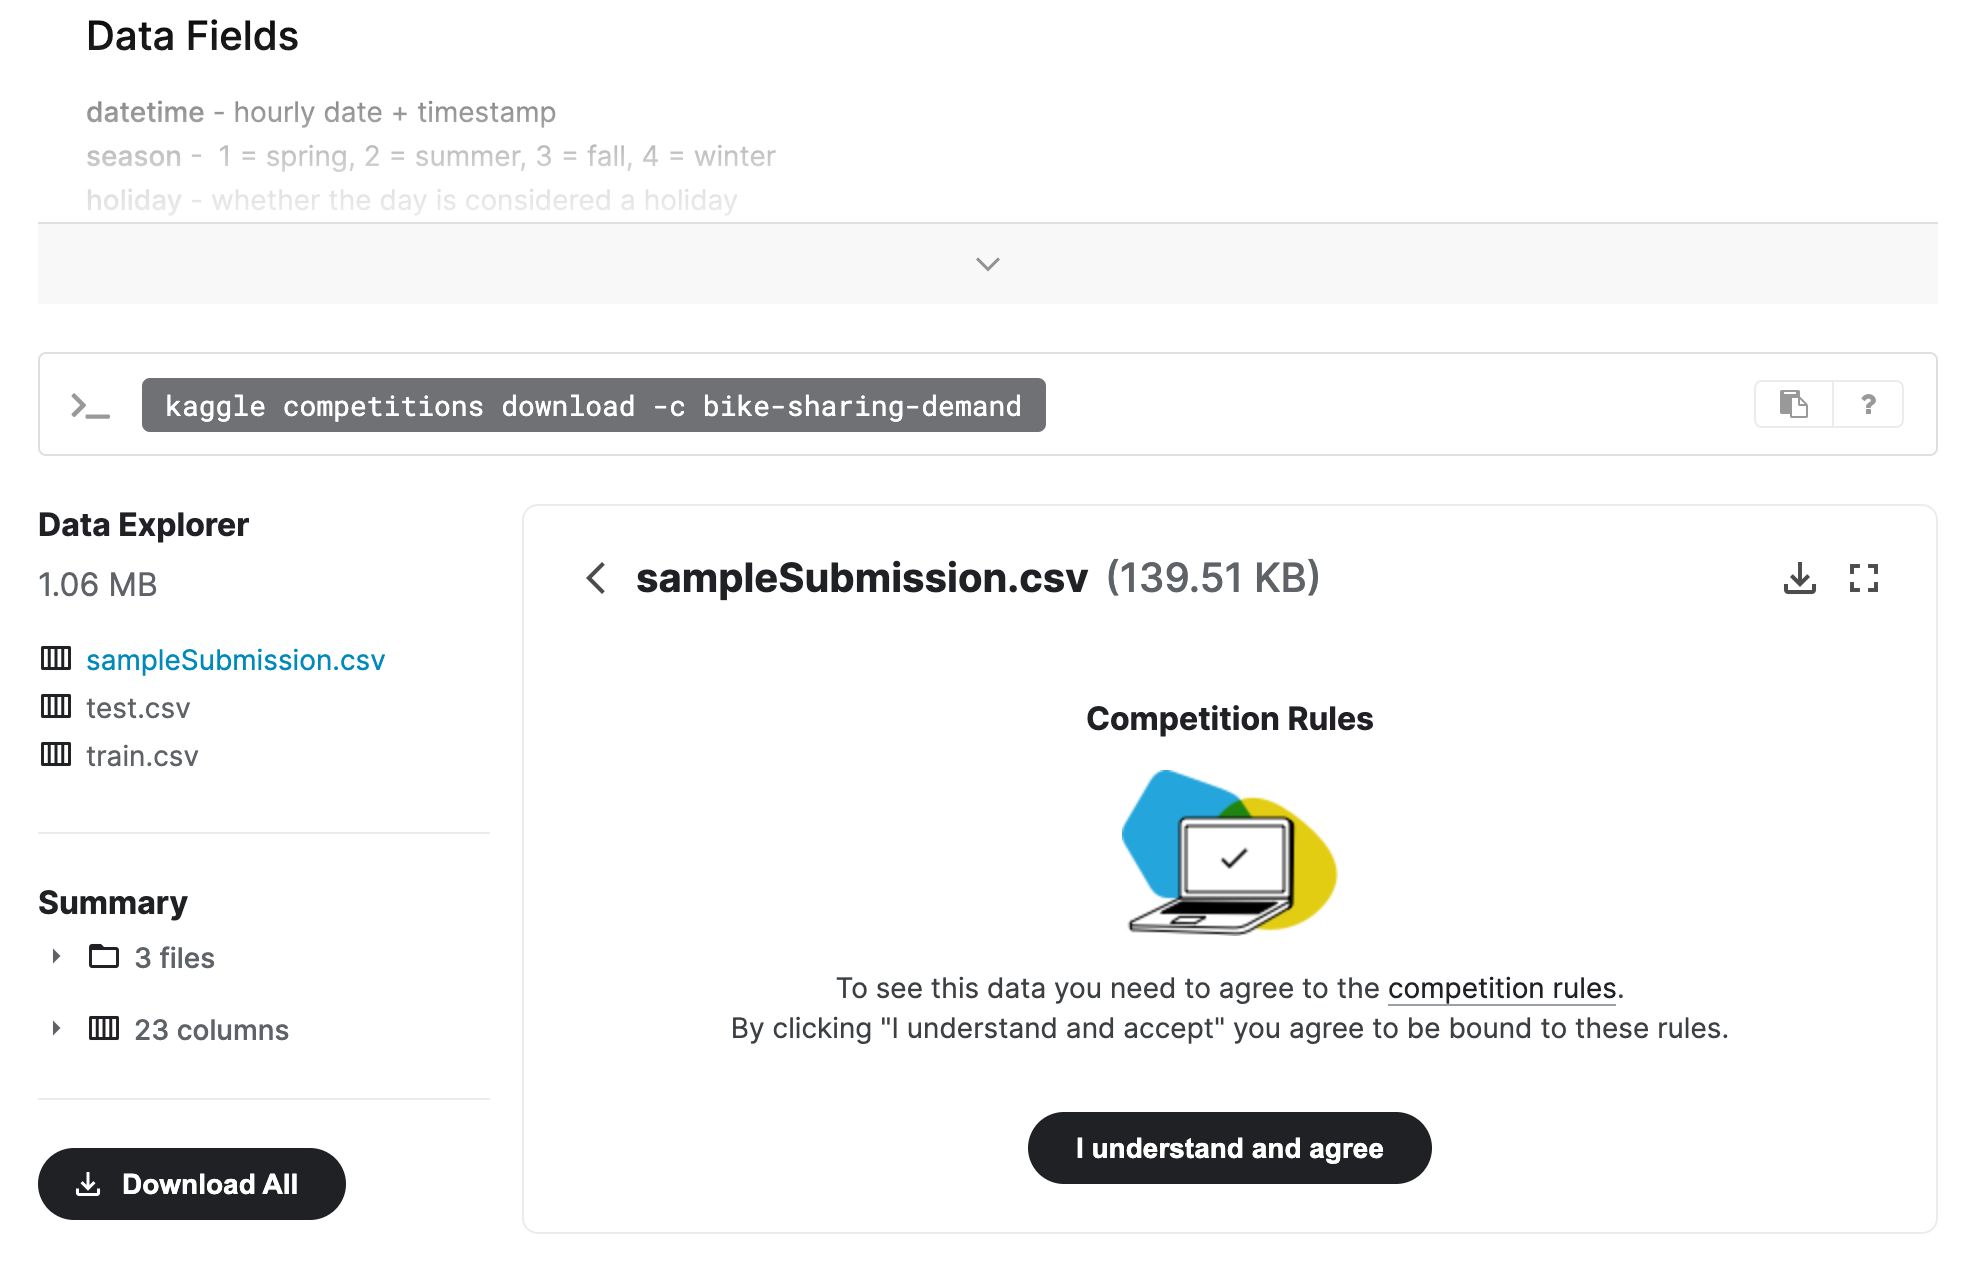

In [5]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [6]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [7]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv", parse_dates=['datetime'])
train.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1

In [8]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed        casual    registered  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886460     12.799395     36.021955    155.552177   
std        8.474601     19.245033      8.164537     49.960477    151.039033   
min        0.760000      0.000000      0.000000      0.000000      0.000000   
25%       16.665000     47.000000      7.001500      4.000000     36.000000   
50%       24.240000     62.000000     12.998000     17.000000    118.000000   
75%       31.060000     77.000000     16.997900     49.000000    222.000000   
max       45.455000    100.000000     56.996900    367.000000    886.000000   

              count  
count  10886.000000  
mean     191.574132  
std      181.144454  
min        1.000000  
25%       42.000000  
50%      145.000000  
75%      284.000000  
max      977.000000

In [9]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv",  parse_dates=['datetime'])
test.head()

datetime  season  holiday  workingday  weather   temp   atemp  \
0 2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
1 2011-01-20 01:00:00       1        0           1        1  10.66  13.635   
2 2011-01-20 02:00:00       1        0           1        1  10.66  13.635   
3 2011-01-20 03:00:00       1        0           1        1  10.66  12.880   
4 2011-01-20 04:00:00       1        0           1        1  10.66  12.880   

   humidity  windspeed  
0        56    26.0027  
1        56     0.0000  
2        56     0.0000  
3        56    11.0014  
4        56    11.0014

In [10]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv")
submission.head()

datetime  count
0  2011-01-20 00:00:00      0
1  2011-01-20 01:00:00      0
2  2011-01-20 02:00:00      0
3  2011-01-20 03:00:00      0
4  2011-01-20 04:00:00      0

## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [11]:
predictor = TabularPredictor(label='count', eval_metric='root_mean_squared_error').fit(
    train_data=train.drop(columns=['casual', 'registered']), time_limit=600,presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240730_024816/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20240730_024816/"
AutoGluon Version:  0.8.3
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Jun 18 14:00:06 UTC 2024
Disk Space Avail:   10.52 GB / 10.73 GB (98.1%)
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: 

### Review AutoGluon's training run with ranking of models that did the best.

In [12]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -53.156712      36.718991  570.607154                0.001469           0.327650            3       True         13
1   RandomForestMSE_BAG_L2  -53.478682      28.801637  448.503629                1.030396          52.128402            2       True         12
2          LightGBM_BAG_L2  -55.032779      28.083266  429.083399                0.312024          32.708171            2       True         11
3        LightGBMXT_BAG_L2  -60.421767      35.375101  485.442930                7.603860          89.067703            2       True         10
4    KNeighborsDist_BAG_L1  -84.125061       0.045478    0.057667                0.045478           0.057667            1       True          2
5      WeightedEnsemble_L2  -84.125061       0.046955    0.961270         

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -131.054161598899,
  'RandomForestMSE_BAG_L1': -116.54835939455667,
  'CatBoost_BAG_L1': -130.79220990614837

### Create predictions from test dataset

In [13]:
predictions =  predictor.predict(test)
predictions.head()

0    23.469097
1    42.562511
2    46.629181
3    49.114582
4    51.991371
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [14]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.616699
std        90.027641
min         3.707647
25%        19.747227
50%        63.791313
75%       167.707443
max       365.083649
Name: count, dtype: float64

In [15]:
# How many negative values do we have?
len(predictions[predictions < 0])

0

In [16]:
# Set them to zero
predictions[predictions < 0] = 0

### Set predictions to submission dataframe, save, and submit

In [17]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [18]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 746kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [19]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2024-07-30 03:01:46  first raw submission               complete  1.8006       1.8006        
submission_new_features.csv  2024-07-30 02:01:08  new features                       complete  0.53735      0.53735       
submission.csv               2024-07-30 01:45:10  first raw submission               complete  1.80234      1.80234       
submission_new_features.csv  2024-07-30 00:23:39  new features                       complete  0.53616      0.53616       


#### Initial score of `?`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'holiday'}>],
       [<Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'weather'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'casual'}>,
        <Axes: title={'center': 'registered'}>,
        <Axes: title={'center': 'count'}>]], dtype=object)

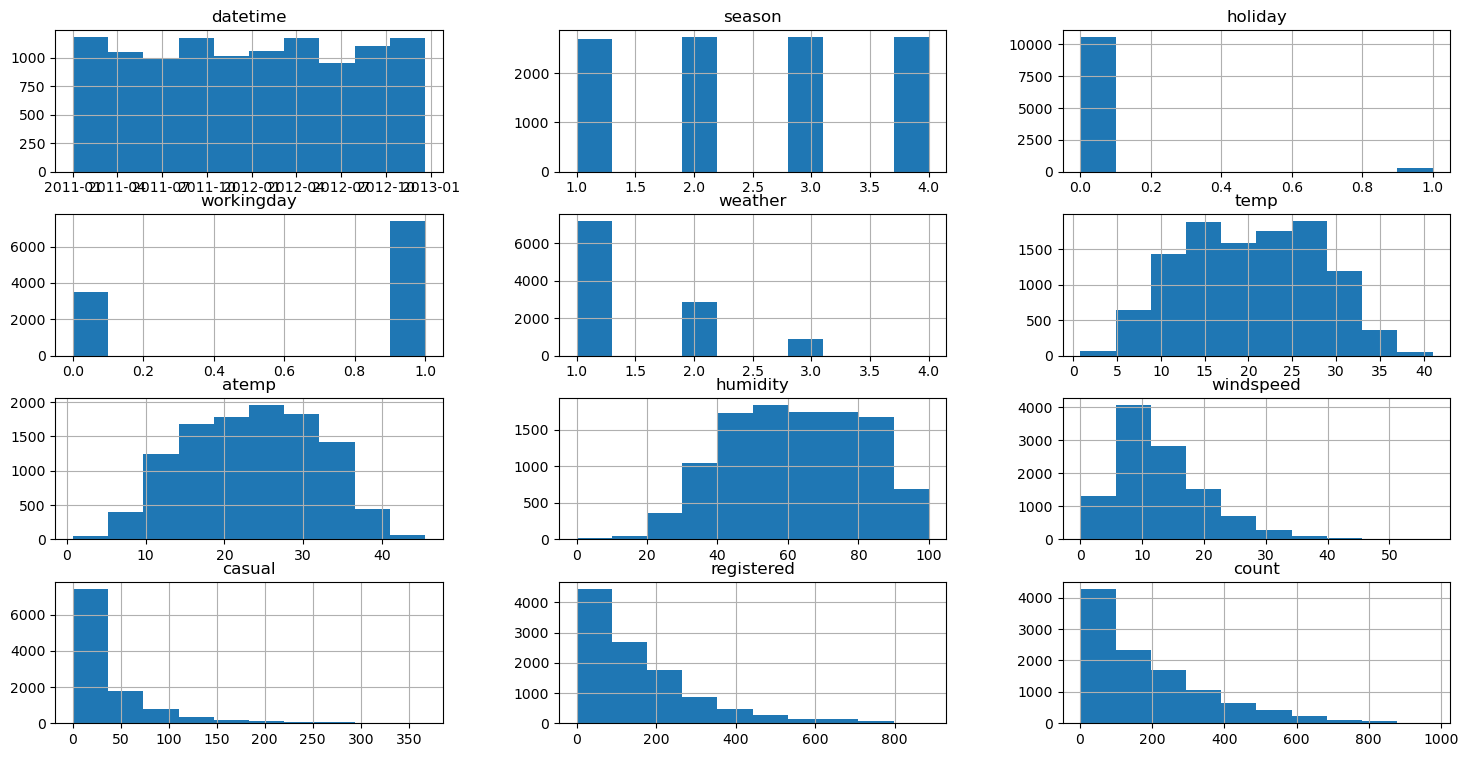

In [20]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(18,9))

In [21]:
# create a new feature
train["hour"] = train["datetime"].astype("datetime64").dt.hour
test["hour"] = test["datetime"].astype("datetime64").dt.hour

train["day"] = train["datetime"].astype("datetime64").dt.day
test["day"] = test["datetime"].astype("datetime64").dt.day

train["month"] = train["datetime"].astype("datetime64").dt.month
test["month"] = test["datetime"].astype("datetime64").dt.month

train.drop(["datetime"], axis=1, inplace=True)
test.drop(["datetime"], axis=1, inplace=True)

/tmp/ipykernel_1893/1455699646.py:2: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  train["hour"] = train["datetime"].astype("datetime64").dt.hour
/tmp/ipykernel_1893/1455699646.py:3: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  test["hour"] = test["datetime"].astype("datetime64").dt.hour
/tmp/ipykernel_1893/1455699646.py:5: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  train["day"] = train["datetime"].astype("datetime64").dt.day
/tmp/ipykernel_1893/1455699646.py:6: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  test["day"] = test["datetime"].astype("datetime64").dt.day
/tmp/ipykernel_1893/1455699646.py:8:

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [22]:
train["season"] = train["season"].astype('category')
train["weather"] = train["weather"].astype('category')
test["season"] = test["season"].astype('category')
test["weather"] = test["weather"].astype('category')

In [23]:
# View are new feature
train.head()

season  holiday  workingday weather  temp   atemp  humidity  windspeed  \
0      1        0           0       1  9.84  14.395        81        0.0   
1      1        0           0       1  9.02  13.635        80        0.0   
2      1        0           0       1  9.02  13.635        80        0.0   
3      1        0           0       1  9.84  14.395        75        0.0   
4      1        0           0       1  9.84  14.395        75        0.0   

   casual  registered  count  hour  day  month  
0       3          13     16     0    1      1  
1       8          32     40     1    1      1  
2       5          27     32     2    1      1  
3       3          10     13     3    1      1  
4       0           1      1     4    1      1

array([[<Axes: title={'center': 'holiday'}>,
        <Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'casual'}>,
        <Axes: title={'center': 'registered'}>,
        <Axes: title={'center': 'count'}>],
       [<Axes: title={'center': 'hour'}>,
        <Axes: title={'center': 'day'}>,
        <Axes: title={'center': 'month'}>]], dtype=object)

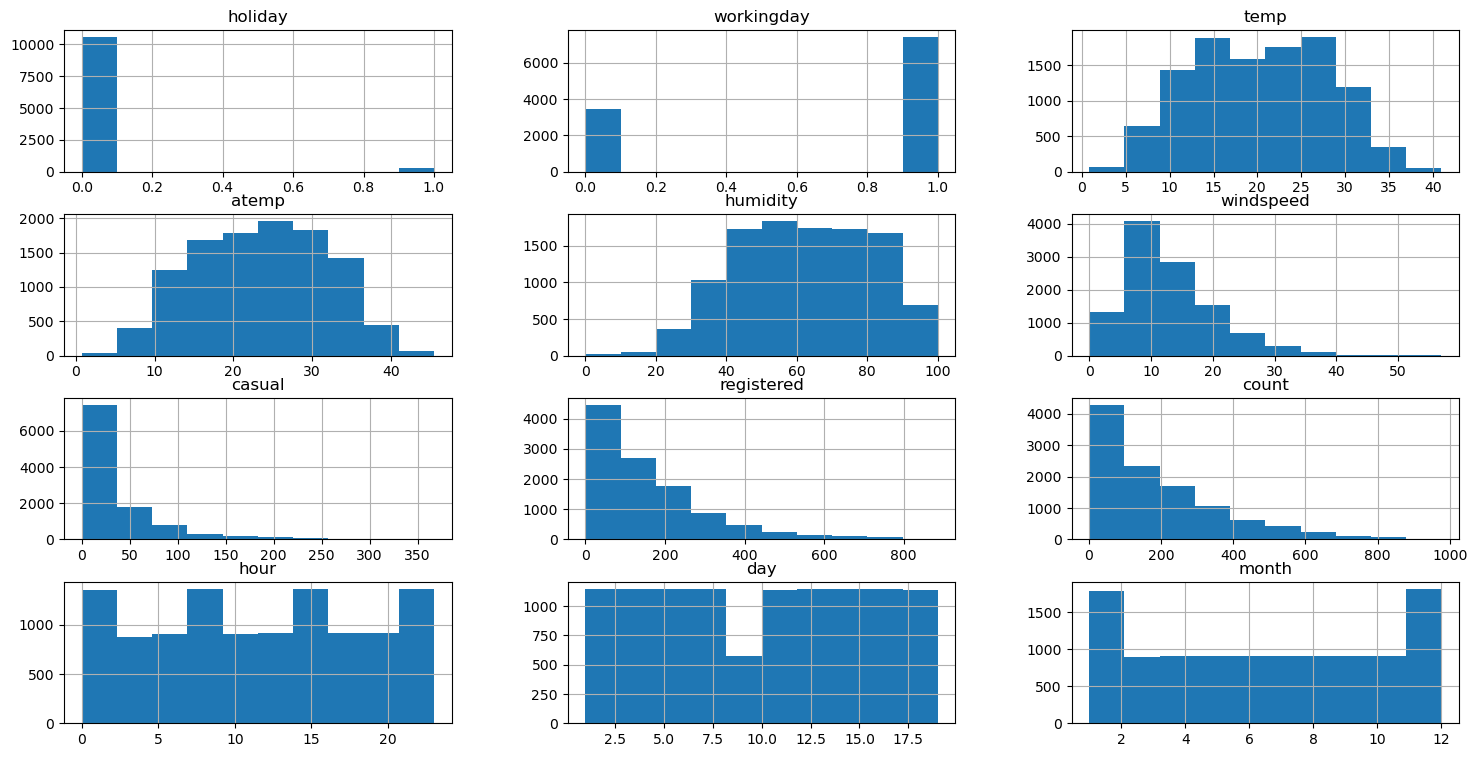

In [24]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(18, 9))

## Step 5: Rerun the model with the same settings as before, just with more features

In [25]:
predictor_new_features = TabularPredictor(label='count', eval_metric='root_mean_squared_error').fit(
    train_data=train.drop(columns=['casual', 'registered']), time_limit=600,presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240730_030204/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20240730_030204/"
AutoGluon Version:  0.8.3
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Jun 18 14:00:06 UTC 2024
Disk Space Avail:   9.45 GB / 10.73 GB (88.1%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specif

In [26]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -50.218716     103.385610  519.764394                0.000818           0.497381            3       True         12
1          CatBoost_BAG_L2  -50.496930     101.523072  442.459603                0.129578          64.985434            2       True         11
2          LightGBM_BAG_L2  -50.949287     101.541884  408.222590                0.148390          30.748422            2       True          9
3   RandomForestMSE_BAG_L2  -51.086754     103.106824  423.533157                1.713329          46.058988            2       True         10
4      WeightedEnsemble_L2  -51.389675     100.645845  315.772045                0.001743           0.675761            2       True          7
5        LightGBMXT_BAG_L2  -52.236893     102.092634  410.881711         

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -123.93326033133259,
  'KNeighborsDist_BAG_L1': -119.36560130583281,
  'LightGBMXT_BAG_L1': -52.705795649247634,
  'LightGBM_BAG_L1': -53.032741303524304,
  'RandomForestMSE_BAG_L1': -64.11630908712874,
  'CatBoost_BAG_L1': -66.06866714168527,
  'WeightedEnsemble_L2': -51.38967489910065,
  'LightGBMXT_BAG_L

In [27]:
# Remember to set all negative values to zero
prediction_new_features=predictor_new_features.predict(test)
prediction_new_features[prediction_new_features < 0] = 0

In [28]:
# Same submitting predictions
submission_new_features = pd.read_csv('sampleSubmission.csv')
submission_new_features["count"] = prediction_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [29]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 719kB/s]
Successfully submitted to Bike Sharing Demand

In [30]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2024-07-30 03:17:25  new features                       pending                              
submission.csv               2024-07-30 03:01:46  first raw submission               complete  1.8006       1.8006        
submission_new_features.csv  2024-07-30 02:01:08  new features                       complete  0.53735      0.53735       
submission.csv               2024-07-30 01:45:10  first raw submission               complete  1.80234      1.80234       


#### New Score of `?`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [31]:
import autogluon.core as ag

# -- GBM Model
gbm_parameters = [
    {
                'num_bag_folds': 6,
                'extra_trees': True,
                'num_boost_round': 100,
                'num_leaves': 50,
                'ag_args': {'name_suffix': '_'}}, {}, 'GBMLarge'
        ]
# -- RF Model
rf_parameters = {'criterion': 'squared_error',
              'ag_args': {'name_suffix': 'MSE'}
             }

# -- XT Model
xt_parameters = {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE'}}

# -- XGB Model
xgb_parameters = [{'objective': 'reg:squarederror',
                'eval_metric': 'rmse',
                'max_depth':  5,
                'n_estimators': 100,
                'eta':.5,
                'subsample': 1,
                'colsample_bytree': 1}]

hyperparameters = {
    'GBM': gbm_parameters,
    'RF': rf_parameters,
    'XT': xt_parameters,
    'XGB' : xgb_parameters

}

hyperparameter_tune_kwargs = { 
                            'num_trials': 5,
                            'scheduler' : 'local',
                            'searcher': 'auto',
                            'time_limit': 600,
                            'search_trategy': 'bayesopt'
}


In [32]:
predictor_new_hpo = TabularPredictor(label="count", problem_type='regression',
                                     eval_metric='root_mean_squared_error'
                                    ).fit(
    hyperparameters = hyperparameters,
    hyperparameter_tune_kwargs = hyperparameter_tune_kwargs,
    train_data=train.drop(columns=['casual', 'registered']),
    presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20240730_031757/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240730_031757/"
AutoGluon Version:  0.8.3
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Jun 18 14:00:06 UTC 2024
Disk Space Avail:   8.54 GB / 10.73 GB (79.6%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1708.16 MB
	Train Data (Original)  Memory Usage: 0.81 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadat

  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
Fitted model: LightGBM__BAG_L1/T1 ...
	-89.1149	 = Validation score   (-root_mean_squared_error)
	36.72s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM__BAG_L1/T2 ...
	-85.2498	 = Validation score   (-root_mean_squared_error)
	34.96s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM__BAG_L1/T3 ...
	-73.7744	 = Validation score   (-root_mean_squared_error)
	34.36s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM__BAG_L1/T4 ...
	-108.6724	 = Validation score   (-root_mean_squared_error)
	34.03s

  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
Fitted model: LightGBM_BAG_L1/T1 ...
	-53.0327	 = Validation score   (-root_mean_squared_error)
	125.3s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T2 ...
	-52.9092	 = Validation score   (-root_mean_squared_error)
	76.62s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T3 ...
	-54.4546	 = Validation score   (-root_mean_squared_error)
	111.36s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T4 ...
	-53.1161	 = Validation score   (-root_mean_squared_error)
	279.5s	 = 

  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
Fitted model: XGBoost_BAG_L1/T1 ...
	-67.1779	 = Validation score   (-root_mean_squared_error)
	25.76s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: XGBoost_BAG_L1/T2 ...
	-76.0922	 = Validation score   (-root_mean_squared_error)
	28.73s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: XGBoost_BAG_L1/T3 ...
	-73.4594	 = Validation score   (-root_mean_squared_error)
	28.35s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: XGBoost_BAG_L1/T4 ...
	-66.7239	 = Validation score   (-root_mean_squared_error)
	29.94s	 = Train

  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
Fitted model: LightGBM__BAG_L2/T1 ...
	-53.3833	 = Validation score   (-root_mean_squared_error)
	31.36s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM__BAG_L2/T2 ...
	-53.1189	 = Validation score   (-root_mean_squared_error)
	34.47s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM__BAG_L2/T3 ...
	-53.0526	 = Validation score   (-root_mean_squared_error)
	35.09s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM__BAG_L2/T4 ...
	-56.3112	 = Validation score   (-root_mean_squared_error)
	36.19s	

  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
Fitted model: LightGBM_BAG_L2/T1 ...
	-52.0571	 = Validation score   (-root_mean_squared_error)
	45.31s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L2/T2 ...
	-52.3895	 = Validation score   (-root_mean_squared_error)
	52.6s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L2/T3 ...
	-52.3022	 = Validation score   (-root_mean_squared_error)
	51.11s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L2/T4 ...
	-52.1471	 = Validation score   (-root_mean_squared_error)
	93.42s	 = Tr

  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
Fitted model: XGBoost_BAG_L2/T1 ...
	-51.7372	 = Validation score   (-root_mean_squared_error)
	28.72s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: XGBoost_BAG_L2/T2 ...
	-52.163	 = Validation score   (-root_mean_squared_error)
	31.95s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: XGBoost_BAG_L2/T3 ...
	-51.9708	 = Validation score   (-root_mean_squared_error)
	30.75s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: XGBoost_BAG_L2/T4 ...
	-51.9462	 = Validation score   (-root_mean_squared_error)
	29.77s	 = Traini

In [33]:
predictor_new_hpo.fit_summary()

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -51.208678      18.276368  1373.523854                0.001407           1.121206            3       True         38
1     ExtraTreesMSE_BAG_L2  -51.500475      18.274482  1152.703606                0.000227          22.780108            2       True         31
2        XGBoost_BAG_L2/T1  -51.737205      18.274383  1158.642206                0.000128          28.718707            2       True         32
3   RandomForestMSE_BAG_L2  -51.902519      18.274463  1227.482825                0.000208          97.559326            2       True         30
4        XGBoost_BAG_L2/T4  -51.946166      18.274400  1159.692851                0.000145          29.769352            2       True         35
5      WeightedEnsemble_L2  -51.959205      18.270264   720.200383  

{'model_types': {'LightGBM__BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM__BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'LightGBM__BAG_L1/T3': 'StackerEnsembleModel_LGB',
  'LightGBM__BAG_L1/T4': 'StackerEnsembleModel_LGB',
  'LightGBM__BAG_L1/T5': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T4': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T5': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'XGBoost_BAG_L1/T1': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T2': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T3': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T4': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T5': 'StackerEnsembleModel_XGBoost',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2'

In [34]:
# Remember to set all negative values to zero
prediction_new_hpo = predictor_new_hpo.predict(test)
prediction_new_hpo[prediction_new_hpo < 0] = 0

In [35]:
# Same submitting predictions
submission_new_hpo = pd.read_csv('sampleSubmission.csv')
submission_new_hpo["count"] = prediction_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [36]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 714kB/s]
Successfully submitted to Bike Sharing Demand

In [37]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2024-07-30 03:59:31  new features with hyperparameters  complete  0.53682      0.53682       
submission_new_features.csv  2024-07-30 03:17:25  new features                       complete  0.54498      0.54498       
submission.csv               2024-07-30 03:01:46  first raw submission               complete  1.8006       1.8006        
submission_new_features.csv  2024-07-30 02:01:08  new features                       complete  0.53735      0.53735       


#### New Score of `?`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

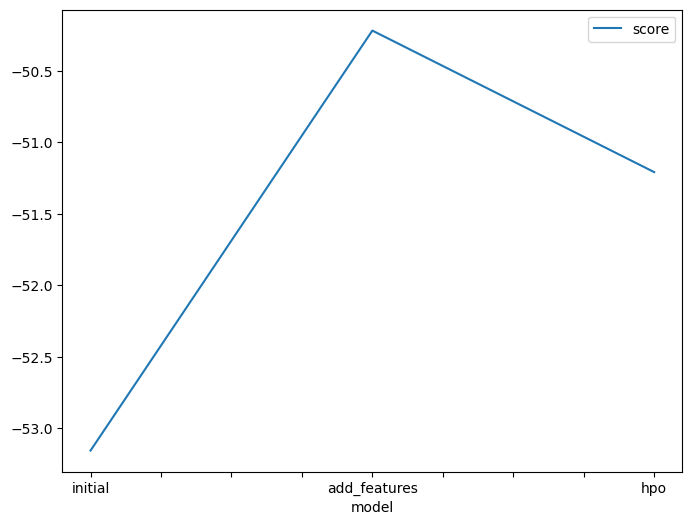

In [40]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score":  [-53.156712, -50.218716, -51.208678]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

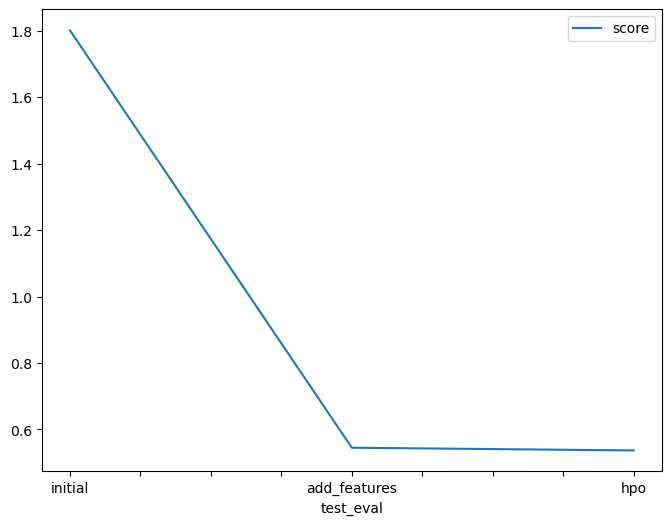

In [41]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score":[1.8006, 0.54498, 0.53682]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [42]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ['presets="best_quality"', 'presets="best_quality"', 'presets="best_quality"'],
    "hpo2": ["Automatic settings", "Automatic settings", "GBM/RF/XT/XGB models"],
    "hpo3": ["Automatic settings", "Automatic settings", "search_trategy: bayesopt"],
    "score":[1.8006, 0.54498, 0.53682]
})

model                    hpo1                  hpo2  \
0       initial  presets="best_quality"    Automatic settings   
1  add_features  presets="best_quality"    Automatic settings   
2           hpo  presets="best_quality"  GBM/RF/XT/XGB models   

                       hpo3    score  
0        Automatic settings  1.80060  
1        Automatic settings  0.54498  
2  search_trategy: bayesopt  0.53682